In [1]:
import tensorflow as tf
import os
import json

import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import tensorflow.image as tfi
from keras.preprocessing.image import load_img, img_to_array

In [2]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import pennylane as qml
from pennylane import numpy as np

In [3]:
import cv2
from glob import glob

In [4]:
np.random.seed(42)

In [5]:
SIZE = 64
CHANNELS = 3
INPUT = (SIZE, SIZE, CHANNELS)

BATCH_SIZE = 64
EPOCHS = 10

RUN = 'run10'

## Data Work

In [6]:
def load_image(image, SIZE):
    # return np.expand_dims(cv2.imread(image)/255.0, axis=-1)
    return np.round(tfi.resize(img_to_array(load_img(image)),(SIZE, SIZE)))

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    
    image_paths = ['.' + path for path in image_paths]
    
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, CHANNELS))
    
    for i,image in enumerate(image_paths):
        img = tf.cast(load_image(image, SIZE), tf.float32) / 255.0
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img
    
    return images

In [7]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [8]:
with open(f"../results-small/{RUN}/paths/train_img_paths.json", "r") as f:
    train_img_paths = json.load(f)

with open(f"../results-small/{RUN}/paths/val_img_paths.json", "r") as f:
    val_img_paths = json.load(f)

with open(f"../results-small/{RUN}/paths/test_img_paths.json", "r") as f:
    test_img_paths = json.load(f)

with open(f"../results-small/{RUN}/paths/train_mask_paths.json", "r") as f:
    train_mask_paths = json.load(f)

with open(f"../results-small/{RUN}/paths/val_mask_paths.json", "r") as f:
    val_mask_paths = json.load(f)

with open(f"../results-small/{RUN}/paths/test_mask_paths.json", "r") as f:
    test_mask_paths = json.load(f)

In [9]:
train_images = load_images(train_img_paths, SIZE)
train_masks = load_images(train_mask_paths, SIZE, mask=True)

In [10]:
len(train_images)

607

In [11]:
val_images = load_images(val_img_paths, SIZE)
val_masks = load_images(val_mask_paths, SIZE, mask=True)

In [12]:
test_images = load_images(test_img_paths, SIZE)
test_masks = load_images(test_mask_paths, SIZE, mask=True)

In [13]:
train_images[0].shape

(64, 64, 3)

In [14]:
# show_image(train_images[0])

In [15]:
# show_mask(train_images[0], train_masks[0], cmap="gray", alpha=1.0)

In [16]:
def iou(y_true, y_pred):
    def f(y_true, y_pred, threshold=0.5):
        y_pred_b = tf.cast(y_pred > threshold, tf.float32)
        intersection = tf.reduce_sum(y_true*y_pred_b, axis=[1, 2, 3])
        union = tf.reduce_sum(y_true + y_pred_b, axis=[1, 2, 3]) - intersection

        iou = intersection/union
        return tf.reduce_mean(iou)
    
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [17]:
def build_unet_model(input_shape=(64, 64, 3)):
   inputs = layers.Input(input_shape)

   # Encoder
   c1 = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(inputs)
   c1 = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(c1)
   p1 = layers.MaxPooling2D((2, 2))(c1)

   c2 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(p1)
   c2 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c2)
   p2 = layers.MaxPooling2D((2, 2))(c2)

   c3 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(p2)
   c3 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c3)
   p3 = layers.MaxPooling2D((2, 2))(c3)

   c4 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(p3)
   c4 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c4)
   p4 = layers.MaxPooling2D((2, 2))(c4)

   c5 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p4)
   c5 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c5)
   p5 = layers.MaxPooling2D((2, 2))(c5)

   # c6 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p5)
   # c6 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c6)
   # p6 = layers.MaxPooling2D((2, 2))(c6)

   b = layers.Conv2D(8, (3,3), activation='relu', name='bottleneck', padding='same')(p5)

   # u1 = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(b)
   # u1 = layers.concatenate([u1, c6], axis=-1)
   # c7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u1)
   # c7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

   u2 = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(b)
   u2 = layers.concatenate([u2, c5], axis=-1)
   c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u2)
   c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c8)

   u3 = layers.Conv2DTranspose(8, (3, 3), strides=(2, 2), padding='same')(c8)
   u3 = layers.concatenate([u3, c4], axis=-1)
   c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u3)
   c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c9)

   u4 = layers.Conv2DTranspose(8, (3, 3), strides=(2, 2), padding='same')(c9)
   u4 = layers.concatenate([u4, c3], axis=-1)
   c10 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u4)
   c10 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c10)

   u5 = layers.Conv2DTranspose(8, (3, 3), strides=(2, 2), padding='same')(c10)
   u5 = layers.concatenate([u5, c2], axis=-1)
   c11 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u5)
   c11 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c11)

   u6 = layers.Conv2DTranspose(4, (3, 3), strides=(2, 2), padding='same')(c11)
   u6 = layers.concatenate([u6, c1], axis=-1)
   c12 = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(u6)
   c12 = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(c12)

   outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c12)

   model = tf.keras.Model(inputs, outputs)

   return model

In [18]:
model = build_unet_model(input_shape = INPUT)

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer= optimizer, loss='binary_crossentropy', metrics=[iou])
# model.compile(optimizer= optimizer, loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryIoU(name='iou'))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 4)            112       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 4)            148       ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 4)            0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [19]:
# Train the model
history = model.fit(
    x = train_images,
    y = train_masks,
    validation_data=(val_images, val_masks),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
)

Epoch 1/10
10/10 [==============================] - 5s 120ms/step - loss: 0.6885 - iou: 0.0170 - val_loss: 0.6814 - val_iou: 4.9663e-04
Epoch 2/10
10/10 [==============================] - 1s 82ms/step - loss: 0.6674 - iou: 6.4810e-04 - val_loss: 0.6455 - val_iou: 0.0072
Epoch 3/10
10/10 [==============================] - 1s 78ms/step - loss: 0.5920 - iou: 0.0508 - val_loss: 0.5019 - val_iou: 0.2858
Epoch 4/10
10/10 [==============================] - 1s 79ms/step - loss: 0.4043 - iou: 0.5138 - val_loss: 0.3411 - val_iou: 0.8217
Epoch 5/10
10/10 [==============================] - 1s 80ms/step - loss: 0.3060 - iou: 0.8008 - val_loss: 0.2965 - val_iou: 0.8532
Epoch 6/10
10/10 [==============================] - 1s 78ms/step - loss: 0.2684 - iou: 0.8527 - val_loss: 0.2606 - val_iou: 0.8786
Epoch 7/10
10/10 [==============================] - 1s 80ms/step - loss: 0.2327 - iou: 0.8864 - val_loss: 0.2158 - val_iou: 0.8834
Epoch 8/10
10/10 [==============================] - 1s 78ms/step - loss: 0

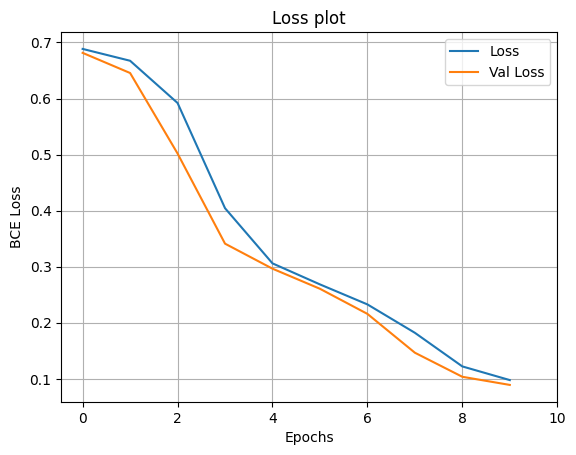

In [20]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("BCE Loss")
plt.title("Loss plot")
plt.xticks(range(0, EPOCHS+1, 2))
plt.legend()
plt.grid(True)
plt.show()

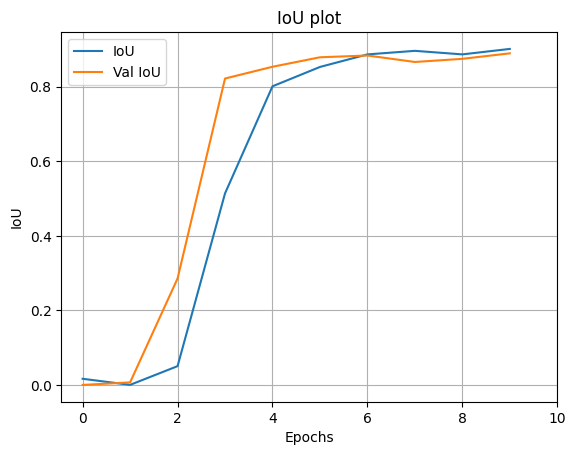

In [21]:
plt.plot(history.history["iou"], label="IoU")
plt.plot(history.history["val_iou"], label="Val IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.title("IoU plot")
plt.xticks(range(0, EPOCHS+1, 2))
plt.legend()
plt.grid(True)
plt.show()

In [22]:
test_loss, test_iou = model.evaluate(x = test_images, y = test_masks)
print(f"Test Loss: {test_loss}")
print(f"Test iou: {test_iou}")

3/3 [==============================] - 0s 27ms/step - loss: 0.0913 - iou: 0.8972
Test Loss: 0.09125646948814392
Test iou: 0.8971728682518005


In [23]:
# Function to visualize a batch of images, ground truth masks, and predictions
def visualize_batch(images, masks, predictions, num_images=5):
    fig, axs = plt.subplots(num_images, 3, figsize=(6, num_images * 3))
    
    for i in range(num_images):
        axs[i, 0].imshow(images[i].squeeze(), cmap="gray", vmin=0, vmax=1)
        axs[i, 0].set_title(f'Image {i+1}')
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(masks[i].squeeze(), cmap="gray", vmin=0, vmax=1)
        axs[i, 1].set_title(f'Ground Truth Mask {i+1}')
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(predictions[i].squeeze(), cmap="gray", vmin=0, vmax=1)
        axs[i, 2].set_title(f'Predicted Mask {i+1}')
        axs[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to get predictions and visualize a batch
def visualize_test_dataset(model, dataset, predictions, num_images=5):
    images, masks = dataset
    # predictions = model.predict(images)
    visualize_batch(images, masks, predictions, num_images=num_images)

In [24]:
predictions = model.predict(test_images)
predictions.shape

3/3 [==============================] - 0s 19ms/step


(76, 64, 64, 1)

In [25]:
np.max(predictions[0])

0.9953731

In [26]:
sample_iou = iou(test_masks, predictions)
print(sample_iou)
print(tf.reduce_mean(sample_iou))

tf.Tensor(0.8982113, shape=(), dtype=float32)
tf.Tensor(0.8982113, shape=(), dtype=float32)


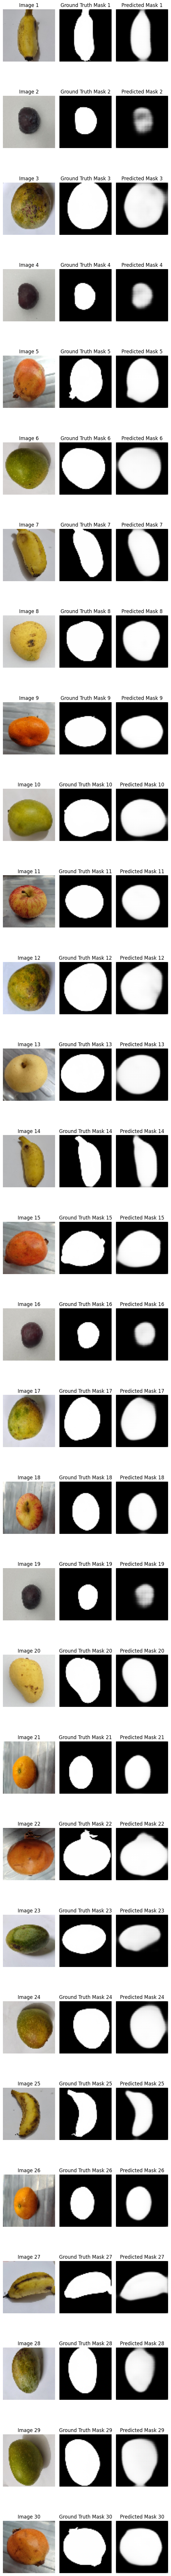

In [27]:
visualize_test_dataset(model, (test_images, test_masks), predictions, num_images=30)

In [28]:
np.save(f"../results-small/{RUN}/unet/predictions.npy", predictions)

In [29]:
model.save_weights(f"../results-small/{RUN}/unet/weights/trained_weights.h5")

In [30]:
np.save(f"../results-small/{RUN}/unet/train_loss.npy", history.history["loss"])
np.save(f"../results-small/{RUN}/unet/val_loss.npy", history.history["val_loss"])

np.save(f"../results-small/{RUN}/unet/train_iou.npy", history.history["iou"])
np.save(f"../results-small/{RUN}/unet/val_iou.npy", history.history["val_iou"])

In [31]:
with open(f"../results-small/consolidated.txt", "a") as f:
    f.writelines([f'{RUN}', '\tU-Net', '\t\ttest_loss: {}'.format(test_loss), '\t\ttest_iou: {}\n'.format(test_iou)])